In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model
"""from tensorflow.keras.preprocessing.image import ImageDataGenerator"""
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import os
import shutil
import sys
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import random as rn
%matplotlib inline

In [ ]:
import os
os.environ['PYTHONHASHEED']='0'

In [ ]:
np.random.seed(1234)

In [4]:
rn.seed(4321)

In [5]:
tf.random.set_seed(1324)

In [6]:
'''from keras import backend as K
sess=tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)'''

'from keras import backend as K\nsess=tf.Session(graph=tf.get_default_graph(), config=session_conf)\nK.set_session(sess)'

In [7]:
#einfach um zu schauen, dass tensorflow das GPU identifizieren kann - wenn 1, dann wurde es identifiziert
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices)) # print out number of GPUs available
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [8]:
#Organize data into train, valid, test dirs
os.chdir(r"C:\Users\ammasi\Desktop\data\surface")
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 2):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 200)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 100)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [9]:
train_path=r"C:\Users\ammasi\Desktop\data\surface\train"
valid_path=r"C:\Users\ammasi\Desktop\data\surface\valid"
test_path=r"C:\Users\ammasi\Desktop\data\surface\test"

In [10]:
'''train_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=test_path, target_size=(224,224), batch_size=10)'''

train_batches_mn = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches_mn = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches_mn = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 37000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
assert train_batches_mn.n == 37000
assert valid_batches_mn.n == 2000
assert test_batches_mn.n == 1000
assert train_batches_mn.num_classes == valid_batches_mn.num_classes==test_batches_mn.num_classes==2

In [12]:
surface=tf.keras.applications.mobilenet.MobileNet()

In [13]:
surface.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [14]:
'''params = count_params(mobile)
assert params['non-trainable_params'] == 21888
assert params['trainable_params'] == 4231976'''

"params = count_params(mobile)\nassert params['non-trainable_params'] == 21888\nassert params['trainable_params'] == 4231976"

## Modify Model

In [15]:
x = surface.layers[-6].output

In [16]:
output = Dense(units=2, activation='sigmoid')(x)

In [17]:
model = Model(inputs=surface.input, outputs=output)

In [18]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [19]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

Total params: 3,230,914
Trainable params: 1,865,730
Non-trainable params: 1,365,184
_________________________________________________________________


In [20]:
'''loss = tf.keras.losses.SparseCategoricalCrossentropy()
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)'''

'loss = tf.keras.losses.SparseCategoricalCrossentropy()\noptim = keras.optimizers.Adam(lr=0.001)\nmetrics = ["accuracy"]\n\nmodel.compile(loss=loss, optimizer=optim, metrics=metrics)'

In [21]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])

In [22]:
model.fit(x=train_batches_mn, validation_data=valid_batches_mn, epochs=2, verbose=2)

Epoch 1/2
3700/3700 - 94s - loss: 0.0173 - accuracy: 0.9949 - val_loss: 0.0032 - val_accuracy: 0.9990
Epoch 2/2
3700/3700 - 98s - loss: 0.0063 - accuracy: 0.9985 - val_loss: 0.0012 - val_accuracy: 0.9995


In [23]:
test_labels = test_batches_mn.classes

In [24]:
predictions = model.predict(x=test_batches_mn, steps=len(test_batches_mn), verbose=0)

In [25]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
test_batches_mn.class_indices

{'0': 0, '1': 1}

Confusion matrix, without normalization
[[500   0]
 [  1 499]]


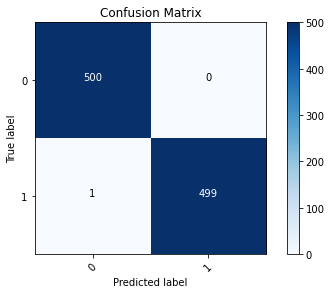

In [28]:
cm_plot_labels = ['0','1']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [29]:
test_batches_mn.class_indices

{'0': 0, '1': 1}

## VVG16

In [31]:
train_batches_vgg16=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=["0", "1"], batch_size=10)
valid_batches_vgg16=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=["0", "1"], batch_size=10)

test_batches_vgg16=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=["0", "1"], batch_size=10, shuffle=False)

Found 37000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [32]:
assert train_batches_vgg16.n == 37000
assert valid_batches_vgg16.n == 2000
assert test_batches_vgg16.n == 1000 
assert train_batches_vgg16.num_classes == valid_batches_vgg16.num_classes==test_batches_vgg16.num_classes==2

In [33]:
imgs, labels = next(train_batches_vgg16)

In [34]:
model=Sequential([
      Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same", input_shape=(224,224, 3)),
      MaxPool2D(pool_size=(2,2), strides=2),
      Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"),
      MaxPool2D(pool_size=(2,2), strides=2),
      Flatten(),
      Dense(units=2, activation ="softmax"),
                 ])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [36]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [37]:
model.fit(x=train_batches_vgg16, validation_data=valid_batches_vgg16, epochs=10, verbose=2)

Epoch 1/10
3700/3700 - 79s - loss: 0.5729 - accuracy: 0.9731 - val_loss: 0.0661 - val_accuracy: 0.9870
Epoch 2/10
3700/3700 - 80s - loss: 0.0325 - accuracy: 0.9925 - val_loss: 0.0441 - val_accuracy: 0.9870
Epoch 3/10
3700/3700 - 85s - loss: 0.0179 - accuracy: 0.9962 - val_loss: 0.0479 - val_accuracy: 0.9890
Epoch 4/10
3700/3700 - 82s - loss: 0.0148 - accuracy: 0.9967 - val_loss: 0.0520 - val_accuracy: 0.9890
Epoch 5/10
3700/3700 - 87s - loss: 0.0190 - accuracy: 0.9969 - val_loss: 0.0496 - val_accuracy: 0.9895
Epoch 6/10
3700/3700 - 105s - loss: 0.0084 - accuracy: 0.9983 - val_loss: 0.0526 - val_accuracy: 0.9915
Epoch 7/10
3700/3700 - 90s - loss: 0.0110 - accuracy: 0.9979 - val_loss: 0.0576 - val_accuracy: 0.9900
Epoch 8/10
3700/3700 - 87s - loss: 0.0134 - accuracy: 0.9978 - val_loss: 0.0957 - val_accuracy: 0.9885
Epoch 9/10
3700/3700 - 86s - loss: 0.0099 - accuracy: 0.9987 - val_loss: 0.1029 - val_accuracy: 0.9875
Epoch 10/10
3700/3700 - 82s - loss: 0.0131 - accuracy: 0.9978 - val_loss

In [38]:
predictions=model.predict(x=test_batches_vgg16, verbose=0)

In [39]:
cm=confusion_matrix(y_true=test_batches_vgg16.classes, y_pred=np.argmax(predictions, axis=-1))

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html    

Confusion matrix, without normalization
[[493   7]
 [  6 494]]


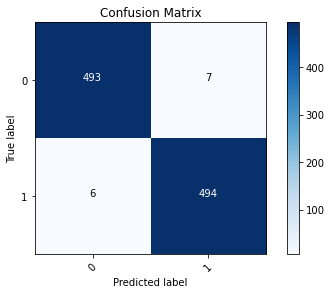

In [55]:
cm_plot_labels=["0", "1"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

## Resnet

In [45]:
train_batches_rn=ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), class_mode='categorical', batch_size=10)

valid_batches_rn=ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), class_mode='categorical', batch_size=10)

test_batches_rn=ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), class_mode='categorical', batch_size=10, shuffle=False)

Found 37000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [46]:
assert train_batches_rn.n == 37000
assert valid_batches_rn.n == 2000 
assert test_batches_rn.n == 1000  
assert train_batches_rn.num_classes == valid_batches_rn.num_classes==test_batches_rn.num_classes==2

In [48]:
surface=tf.keras.applications.resnet.ResNet50()

102973440/102967424 [==============================] - 14s 0us/step


In [49]:
surface.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [50]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])

In [51]:
model.fit(x=train_batches_rn, validation_data=valid_batches_rn, epochs=10, verbose=2)

Epoch 1/10
3700/3700 - 80s - loss: 0.0129 - accuracy: 0.9978 - val_loss: 0.0980 - val_accuracy: 0.9860
Epoch 2/10
3700/3700 - 86s - loss: 0.0096 - accuracy: 0.9984 - val_loss: 0.0789 - val_accuracy: 0.9880
Epoch 3/10
3700/3700 - 80s - loss: 0.0130 - accuracy: 0.9979 - val_loss: 0.1495 - val_accuracy: 0.9810
Epoch 4/10
3700/3700 - 80s - loss: 0.0178 - accuracy: 0.9972 - val_loss: 0.1120 - val_accuracy: 0.9845
Epoch 5/10
3700/3700 - 80s - loss: 0.0100 - accuracy: 0.9986 - val_loss: 0.0999 - val_accuracy: 0.9865
Epoch 6/10
3700/3700 - 81s - loss: 0.0043 - accuracy: 0.9992 - val_loss: 0.1151 - val_accuracy: 0.9865
Epoch 7/10
3700/3700 - 81s - loss: 0.0128 - accuracy: 0.9982 - val_loss: 0.0979 - val_accuracy: 0.9885
Epoch 8/10
3700/3700 - 80s - loss: 0.0062 - accuracy: 0.9990 - val_loss: 0.0942 - val_accuracy: 0.9885
Epoch 9/10
3700/3700 - 98s - loss: 0.0100 - accuracy: 0.9986 - val_loss: 0.0968 - val_accuracy: 0.9870
Epoch 10/10
3700/3700 - 83s - loss: 0.0131 - accuracy: 0.9986 - val_loss:

In [52]:
predictions=model.predict(x=test_batches_rn, verbose=0)

In [53]:
cm=confusion_matrix(y_true=test_batches_vgg16.classes, y_pred=np.argmax(predictions, axis=-1))

In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html    

Confusion matrix, without normalization
[[493   7]
 [  6 494]]


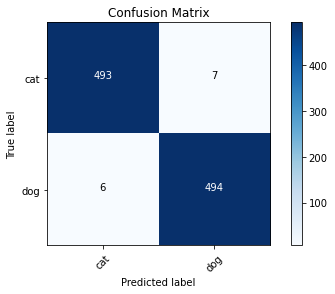

In [56]:
cm_plot_labels=["cat", "dog"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")